### Задача
Анализ аномалий в аренде велосипедов в лондоне

### Данные

In [31]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
import seaborn as sns

In [2]:
df = pd.read_csv('london.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


- timestamp – дата и время (точность до часа)
- cnt – количество аренд велосипедов за этот час
- t1 – температура, в С
- t2 – температура "ощущается как", в С 
- hum – влажность (%)
- wind_speed – скорость ветра, км/ч
- weather_code – погодные условия: \
    1 – ясно (SKC) \
    2 – преимущественно ясно / встречаются отдельные облака (SCT) \
    3 – облачно / значительные облака (BKN) \
    4 – пасмурно (OVC) \
    7 – небольшой дождь Rain/ light Rain shower/ Light rain \
    10 – дождь с грозой \
    26 – снегопад \
    94 – ледяной туман
- isholiday – является ли день праздником (1 – праздник, 0 – нет)
- isweekend –  является ли день выходным (1 – выходной, 0 – нет)
- season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

#### Проверка корректности

Пропуски

In [3]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Приведение типов

In [4]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [5]:
df.timestamp = pd.to_datetime(df.timestamp)
df.is_holiday = df.is_holiday.astype('bool')
df.is_weekend = df.is_weekend.astype('bool')

In [6]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday                bool
is_weekend                bool
season                 float64
dtype: object

### Решение

In [7]:
# Настройка графиков
sns.set(
    font_scale=1.5, 
    style='whitegrid', 
    rc={'figure.figsize': (20, 7)}
)

Почасовые аренды

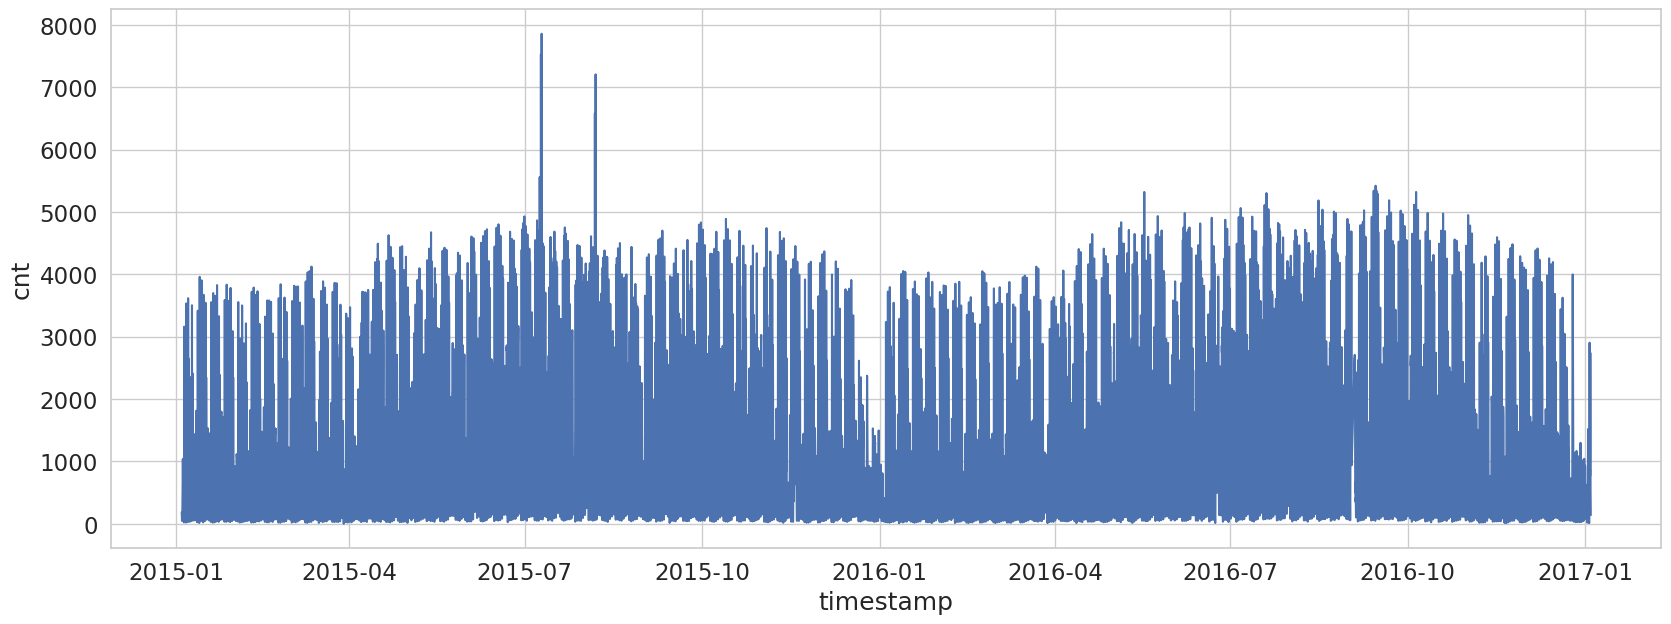

In [8]:
sns.lineplot(data=df, x=df.timestamp, y=df.cnt);

Ежедневные аренды

In [9]:
day_cnt_df = df.resample(rule='D', on='timestamp').cnt.sum().to_frame()
day_cnt_df.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


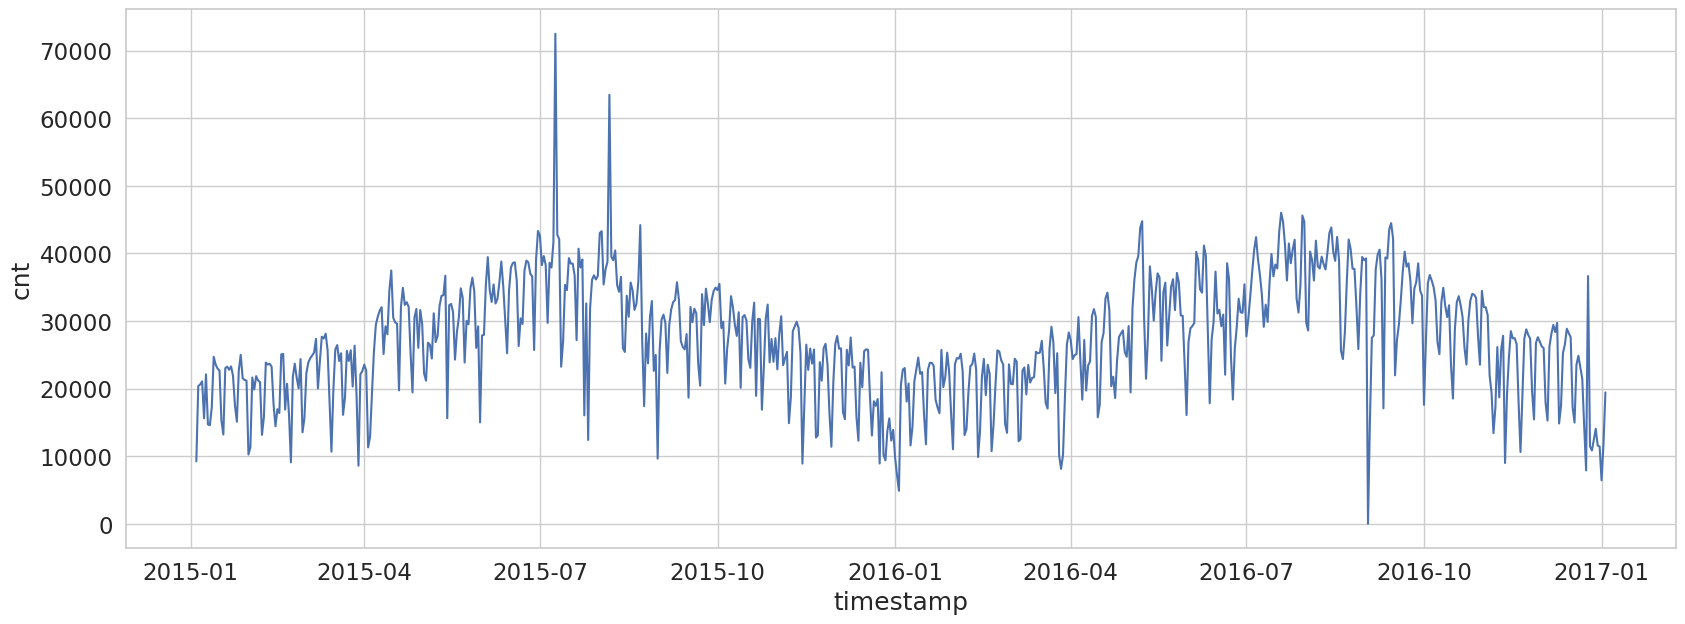

In [11]:
sns.lineplot(data=day_cnt_df, x='timestamp', y='cnt');

На графике заметны дни с аномально высоким/изким количеством поездок

**Детектирование аномалий**

Общий алгоритм:
- выделить высокочастотную составляющую графика
- опрделить её ДИ
- детектировать аномалии, как выбросы за ДИ

_Выделение низкочастотной составляющей с помощью скользящего среднего_

In [14]:
low_freq_df = day_cnt_df.rolling(3).mean()

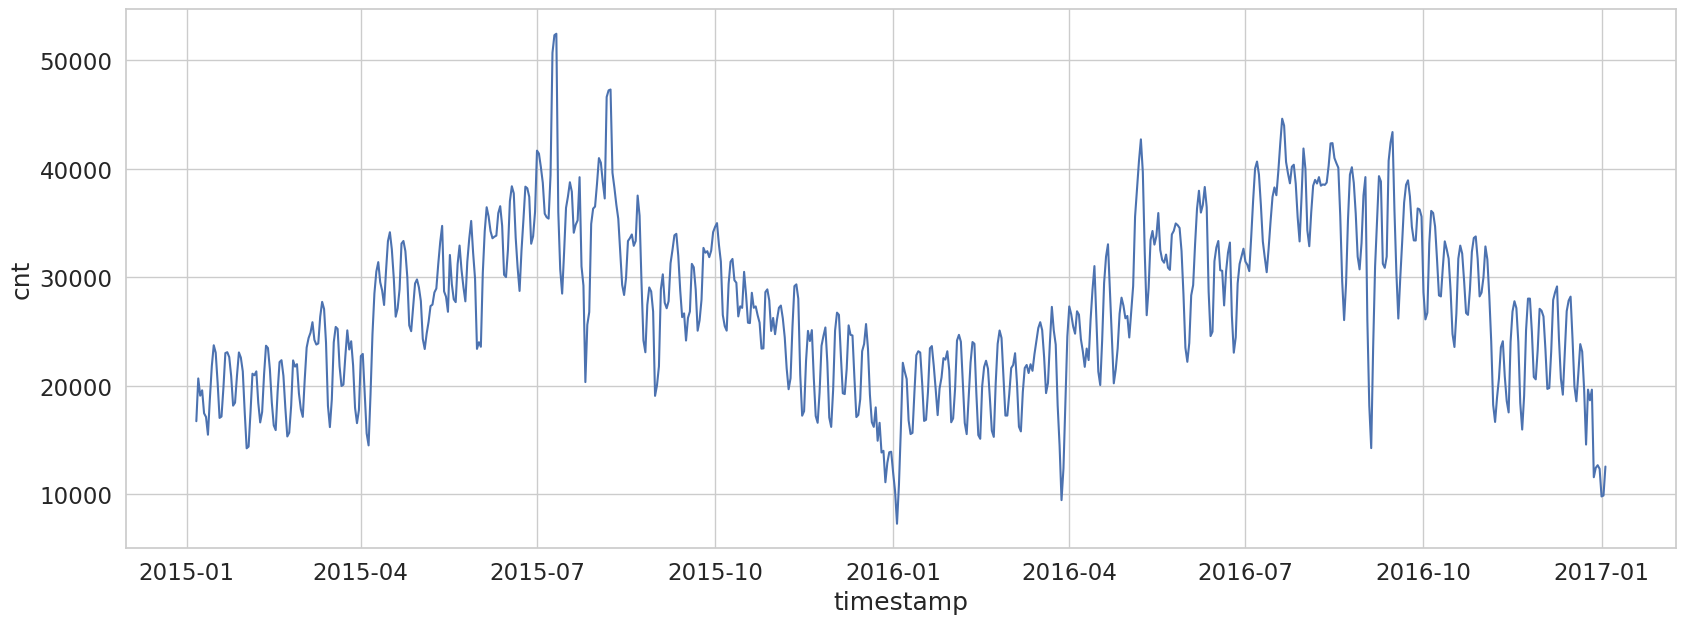

In [15]:
sns.lineplot(data=low_freq_df, x='timestamp', y='cnt');

_Выделение высокочастотной составляющей_

In [16]:
high_freq_df = day_cnt_df - low_freq_df

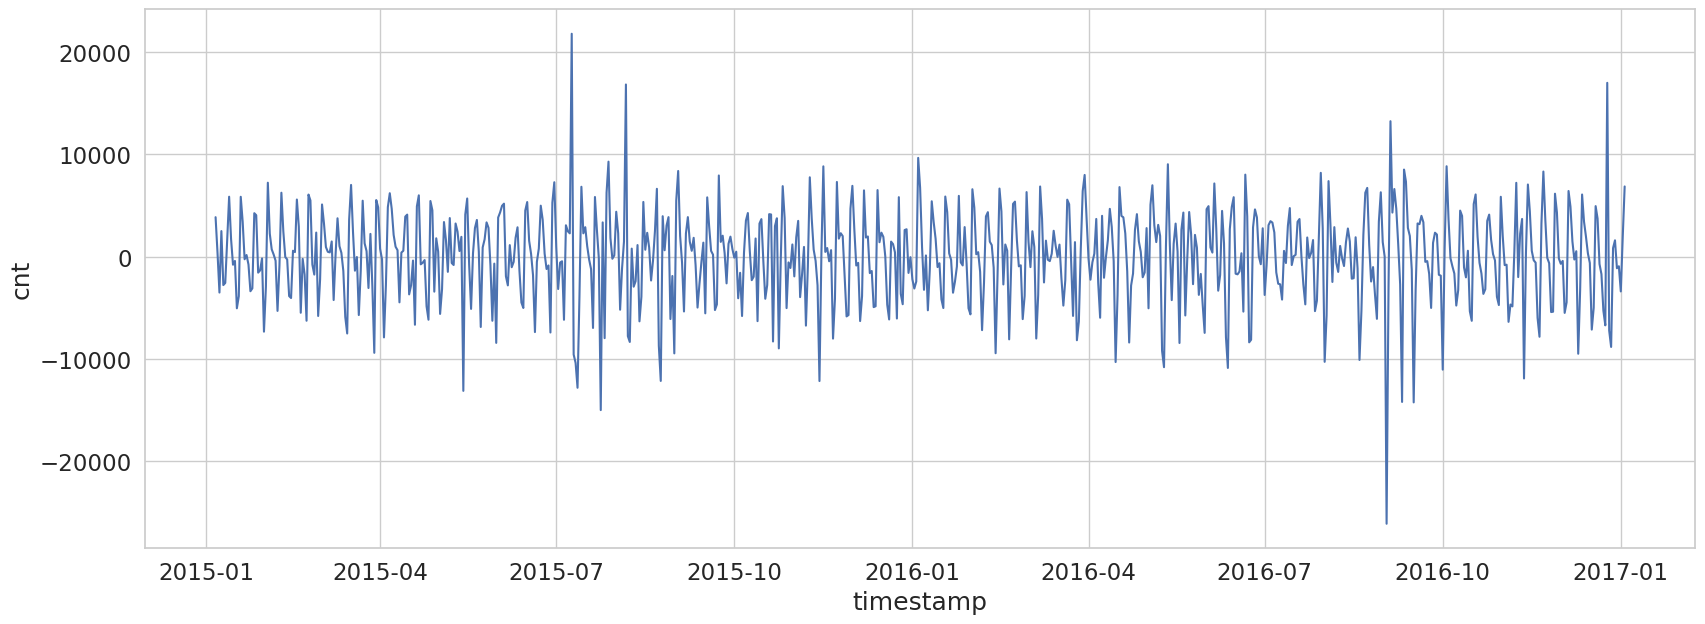

In [19]:
sns.lineplot(data=high_freq_df, x='timestamp', y='cnt');

_Определение ДИ_

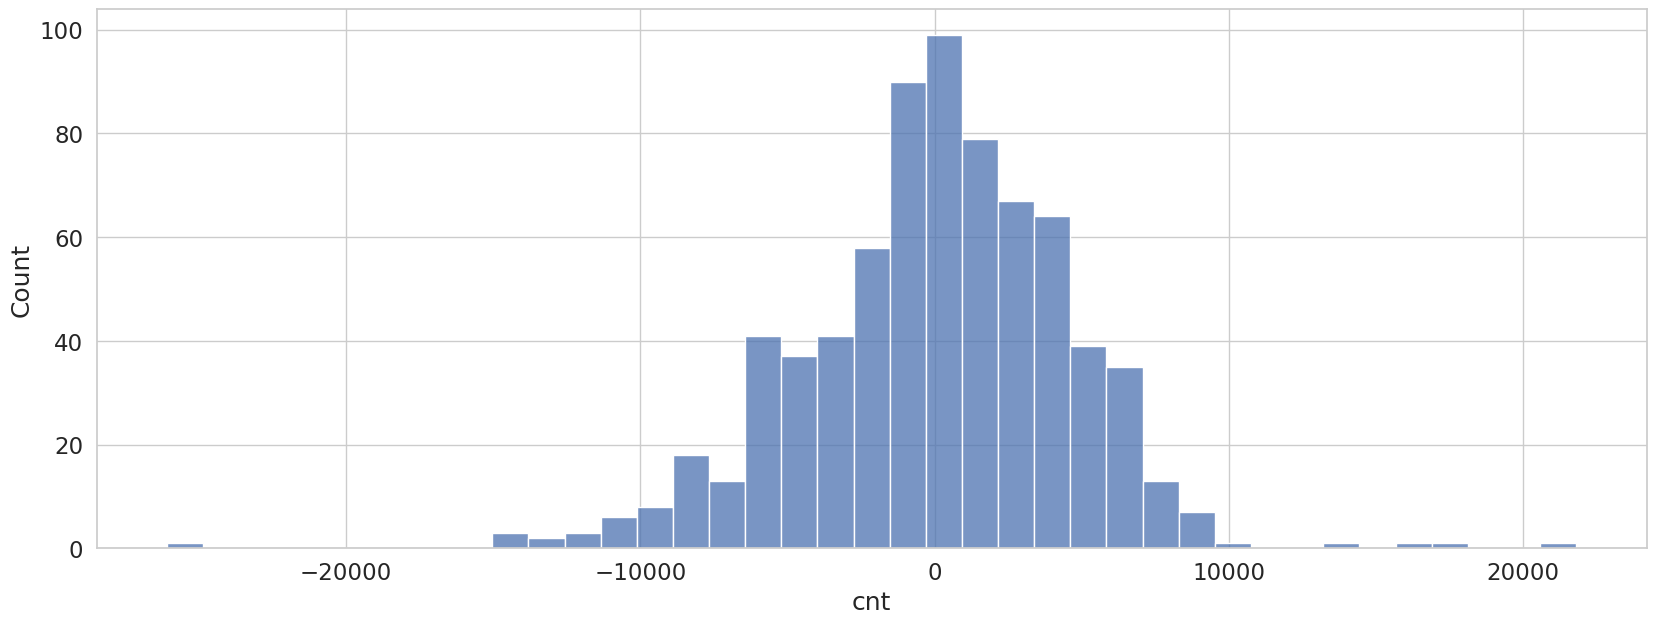

In [28]:
sns.histplot(high_freq_df.cnt.dropna());

In [30]:
ss.normaltest(high_freq_df.cnt.dropna())

NormaltestResult(statistic=58.29429378316958, pvalue=2.1956086938120343e-13)

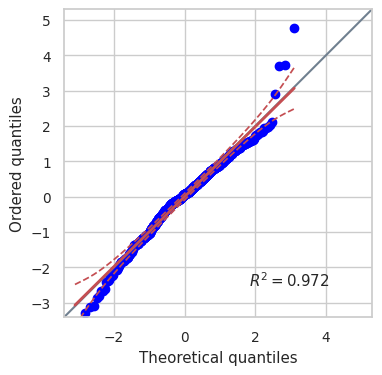

In [38]:
# Настройка графиков
sns.set(
    font_scale=.9, 
    style='whitegrid', 
    rc={'figure.figsize': (7, 4)}
)

pg.qqplot(high_freq_df.cnt.dropna());

=> критическое значение нормального распределения для построения ДИ не подходит

ДИ по квантилям

In [126]:
def get_ci(
    data,
    ci_probability=99
):
    '''
    Функция возвращает границы дискретного ДИ (a, b]
    
    Parameters
    ----------
    data: pandas.Series
        Данные, для которых необходимо построить ДИ
    ci_probability: float, default 95
        % вероятности попадения наблюдения в интервал
        
    Returns
    -------
    ci: list
        Кортеж границ ДИ (a, b]
    '''
    outlier_probability = 1 - ci_probability/100
    one_way_outlier = outlier_probability / 2
    
    ci_a = high_freq_df.cnt.dropna().quantile(one_way_outlier)
    ci_b = high_freq_df.cnt.dropna().quantile(1 - one_way_outlier)
    
    return (ci_a, ci_b)

In [127]:
ci = get_ci(high_freq_df.cnt.dropna())
ci

(-13489.73333333333, 10958.173333333383)

_Поиск аномалий_

In [128]:
high_freq_df['is_anomaly'] = (
    high_freq_df.cnt
    .apply(lambda x: False if ci[0]<x<=ci[1] else True)
)
high_freq_df

,cnt,anomaly,ci_a,ci_b,is_anomaly
timestamp,,,,,
2015-01-04,NaN,True,-14185.901333,13568.714667,True
2015-01-05,NaN,True,-14185.901333,13568.714667,True
2015-01-06,3873.333333,False,-14185.901333,13568.714667,False
2015-01-07,381.000000,False,-14185.901333,13568.714667,False
2015-01-08,-3491.666667,False,-14185.901333,13568.714667,False
...,...,...,...,...,...
2016-12-30,-1116.000000,False,-14185.901333,13568.714667,False
2016-12-31,-923.333333,False,-14185.901333,13568.714667,False
2017-01-01,-3382.666667,False,-14185.901333,13568.714667,False


In [129]:
anomaly_df = high_freq_df.dropna().query('is_anomaly == True')
anomaly_df.head()

,cnt,anomaly,ci_a,ci_b,is_anomaly
timestamp,,,,,
2015-07-09,21799.000000,True,-14185.901333,13568.714667,True
2015-07-24,-14979.666667,True,-14185.901333,13568.714667,True
2015-08-06,16840.666667,False,-14185.901333,13568.714667,True
2016-09-02,-26086.333333,True,-14185.901333,13568.714667,True
2016-09-04,13253.000000,False,-14185.901333,13568.714667,True


In [130]:
anomaly_df.shape

(8, 5)

In [131]:
high_freq_plot_df = high_freq_df
high_freq_plot_df['ci_a'] = ci[0]
high_freq_plot_df['ci_b'] = ci[1]

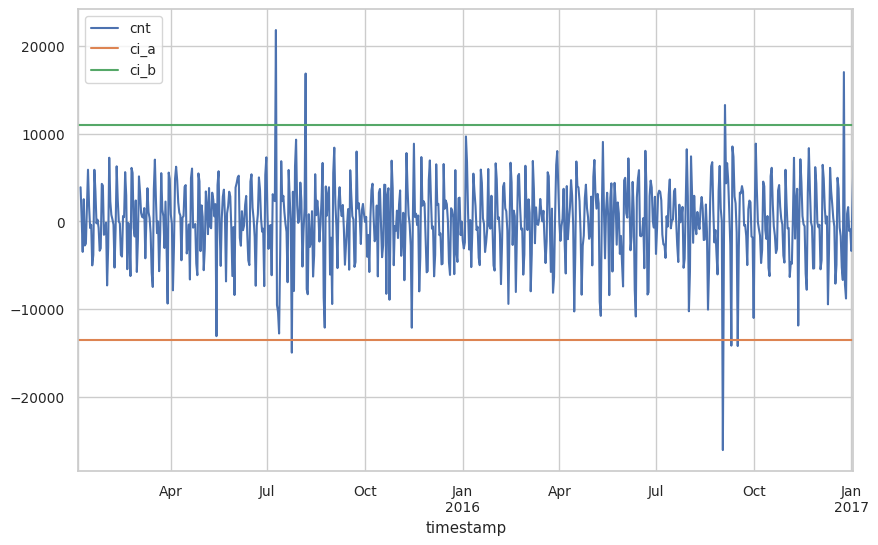

In [132]:
# Настройка графиков
sns.set(
    font_scale=.9, 
    style='whitegrid', 
    rc={'figure.figsize': (10, 6)}
)

high_freq_plot_df.plot();

Положительные аномалии

In [134]:
good_anomalies = high_freq_plot_df.query('cnt > 0 and is_anomaly == True')
good_anomalies

,cnt,anomaly,ci_a,ci_b,is_anomaly
timestamp,,,,,
2015-07-09,21799.000000,True,-13489.733333,10958.173333,True
2015-08-06,16840.666667,False,-13489.733333,10958.173333,True
2016-09-04,13253.000000,False,-13489.733333,10958.173333,True
2016-12-25,17002.333333,True,-13489.733333,10958.173333,True


Отрицательные аномалии

In [136]:
bad_anomalies = high_freq_plot_df.query('cnt < 0 and is_anomaly == True')
bad_anomalies

,cnt,anomaly,ci_a,ci_b,is_anomaly
timestamp,,,,,
2015-07-24,-14979.666667,True,-13489.733333,10958.173333,True
2016-09-02,-26086.333333,True,-13489.733333,10958.173333,True
2016-09-10,-14182.000000,False,-13489.733333,10958.173333,True
2016-09-16,-14226.333333,False,-13489.733333,10958.173333,True


#### Анализ аномалии за 2015-07-09

In [140]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,False,True,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,False,True,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,False,True,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,False,True,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,False,True,3.0


In [148]:
anomaly_date_df = df.loc[df.timestamp.dt.to_period('D') == '2015-07-09']
anomaly_date_df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1.0,False,False,1.0
4454,2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1.0,False,False,1.0
4455,2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1.0,False,False,1.0
4456,2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1.0,False,False,1.0
4457,2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1.0,False,False,1.0


In [89]:
anomaly_date_df.shape

(24, 10)

In [142]:
anomaly_date_df.timestamp.nunique()

24

Повторений дат нет

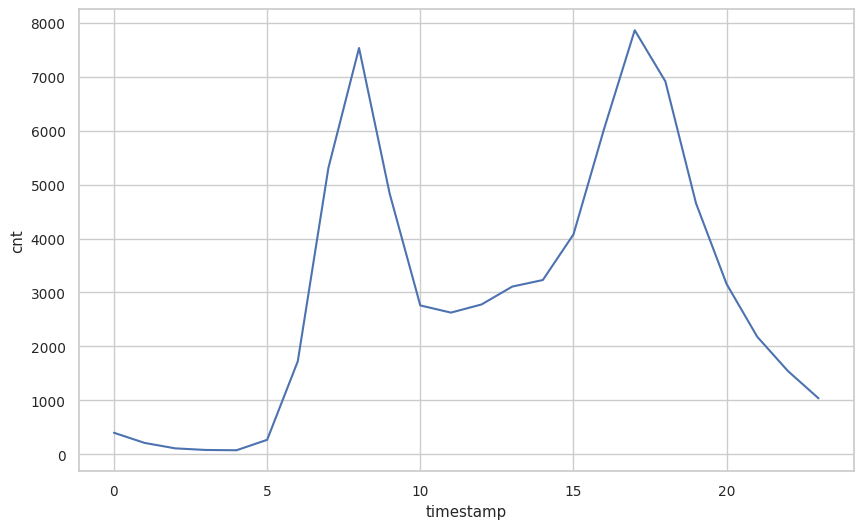

In [143]:
sns.lineplot(data=anomaly_date_df, x=anomaly_date_df.timestamp.dt.hour, y='cnt');

Имеется 2 резких пика - утренний и вечерний

Медианное число аренд в час

In [145]:
# Всё время
df.cnt.median()

844.0

In [147]:
# Аномалия
anomaly_date_df.cnt.median()

2769.0

In [149]:
anomaly_date_df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1.0,False,False,1.0
4454,2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1.0,False,False,1.0
4455,2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1.0,False,False,1.0
4456,2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1.0,False,False,1.0
4457,2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1.0,False,False,1.0
4458,2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1.0,False,False,1.0
4459,2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1.0,False,False,1.0
4460,2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1.0,False,False,1.0
4461,2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2.0,False,False,1.0
4462,2015-07-09 09:00:00,4832,15.0,15.0,59.0,16.0,2.0,False,False,1.0


Т.о. данные представлены за июль 2015. Это обычный ясный день. Не праздник, не выходной. Аномалий в параметрах атмосферы не обнаружено

Мб день сам по себе особенный?



Действительно, [день особенный](https://rg.ru/2015/07/09/london-site-anons.html)

- Местное метро начало работать по выходным
- ЗП работников метрополитена не изменилась
- Работники метрополитена начали забастовки
- Работа метро парализовалась
- Горожанам пришлось пересесть на общественный транспорт и велосипеды :)

*Пики на дневном графике - люди едут на работу и домой

Inspired by: KCM7L3P

### Идеи для улучшения:
- анализ остальных дат